# define dataset

In [3]:
import torch
import torchvision
import numpy as np

In [4]:
from torchvision.datasets import ImageFolder as ImageFolder

In [43]:
d_path = r"C:\Users\zhouy\source\repos\GameScriptLib\src\app\epic7\resources\photo\RTA_classification"
train_transform = torchvision.transforms.ToTensor()
dataset = ImageFolder(root=d_path, transform=train_transform)

In [44]:
len(dataset)

371

In [6]:
from matplotlib import pyplot as plt

In [8]:
img = (dataset[200][0].numpy() * 255).astype(np.uint8)

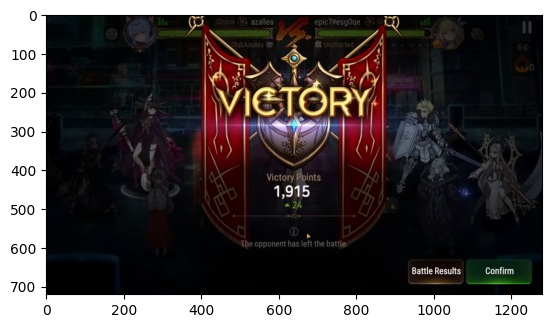

In [9]:
plt.imshow(img.transpose((1,2,0)))  # [RGB]

# define network

In [10]:
import torch
import torch.nn as nn

In [11]:
class Conv2d(nn.Module):
    def __init__(self, c1,c2,k,s,p):
        super().__init__()
        self.conv = nn.Conv2d(c1,c2,k,s,p)
        self.bn = nn.BatchNorm2d(c2)
        self.prelu = nn.PReLU(c2)

    def forward(self,x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.prelu(x)
        return x

In [12]:
class SimpleNet(nn.Module):
    def __init__(self, class_num):
        super().__init__()
        self.conv1 = Conv2d(3,8,3,2,1)
        self.conv2 = Conv2d(8,16,3,2,1)
        self.conv3 = Conv2d(16,32,3,2,1)
        self.pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(32, class_num)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.pool(x)
        x = x.reshape(x.shape[0],-1)
        x = self.fc(x)
        return x

## test network

In [13]:
net = SimpleNet(5)

In [14]:
input = torch.rand(1,3,720,1280)
net.eval()
output = net(input)

In [15]:
output.shape

torch.Size([1, 5])

# train network

In [27]:
def make_weights_for_balanced_classes(images, nclasses):
    count = [0] * nclasses
    for item in images:
        count[item[1]] += 1
    weight_per_class = [0.] * nclasses
    N = float(sum(count))
    for i in range(nclasses):
        weight_per_class[i] = N/float(count[i])
    weight = [0] * len(images)
    for idx, val in enumerate(images):
        weight[idx] = weight_per_class[val[1]]
    return weight

In [31]:
from torch.utils.data import DataLoader as DataLoader
def balance_loader(isBlc=True):
    if isBlc:
        weights = make_weights_for_balanced_classes(dataset.imgs, len(dataset.classes))
        weights = torch.DoubleTensor(weights)
        sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))
    else:
        sampler = None
    loader = DataLoader(dataset, batch_size=16, shuffle=sampler is None, sampler = sampler)
    return loader

In [45]:
torch.cuda.set_device(0)
loader = balance_loader(True)

In [ ]:
net = SimpleNet(5)
net.cuda()
net.train()

In [47]:
from torcheval.metrics import MulticlassAccuracy
metric = MulticlassAccuracy(device="cuda")
weight = torch.tensor([1,1,1,1,1]).float().cuda()
criterion = nn.CrossEntropyLoss(weight)

## train acc

In [48]:
from tqdm import tqdm
optimizer = torch.optim.AdamW(params = net.parameters(), lr=1e-3)
maxepoch = 100

for epoch in range(maxepoch):
    pbar = tqdm(loader)
    total_loss,cnt = 0,0
    metric.reset()
    for img,label in pbar:
        img = img.cuda()
        label = label.cuda().long()
        out = net(img)
        metric.update(out,label)
        loss = criterion(out,label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        cnt += 1
        pbar.set_description("epoch: {} , loss: {:.4f}, acc: {:.2f}".format(epoch, total_loss/cnt, metric.compute()))


  0%|                                                                                           | 0/24 [00:08<?, ?it/s]

epoch: 99 , loss: 0.0854, acc: 0.99: 100%|█████████████████████████████████████████████| 24/24 [00:07<00:00,  3.00it/s]


### train acc for each class

In [49]:
class cm_matrix:
    def __init__(self, num_classes):
        self.cm = torch.zeros(num_classes, num_classes)
        self.num_classes = num_classes

    def update(self, pred, target):
        pred = torch.argmax(pred,dim=1)
        for p,t in zip(pred.cpu(), label.cpu()):
            self.cm[t,p] += 1

    def show(self):
        for i in range(self.num_classes):
            print('acc for class {} is {}/{}'.format(i, self.cm[i,i], self.cm.sum(1)[i]))

In [50]:
metric = cm_matrix(5)
loader = balance_loader(False)
for img,label in loader:
    img = img.cuda()
    out = net(img)  
    metric.update(out, label)   

In [51]:
metric.show()

acc for class 0 is 103.0/111.0
acc for class 1 is 121.0/140.0
acc for class 2 is 60.0/60.0
acc for class 3 is 35.0/38.0
acc for class 4 is 22.0/22.0


In [52]:
print(metric.cm)

tensor([[103.,   0.,   1.,   2.,   5.],
        [  2., 121.,  15.,   2.,   0.],
        [  0.,   0.,  60.,   0.,   0.],
        [  1.,   0.,   0.,  35.,   2.],
        [  0.,   0.,   0.,   0.,  22.]])


## save model

In [53]:
torch.save(net,"../assert/rta_cls.pt")